<a href="https://colab.research.google.com/github/jumbokh/nknu-class/blob/main/notebooks/CNN_1_real_diff_from_chap4_visualizing_what_convnets_learn_3_heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 說明
1. 請將DNN_CNN.zip放在同 COLAB 帳號的雲端硬碟根目錄底下
2.然後執行下列程式。

[Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization
](https://arxiv.org/abs/1610.02391)


In [ ]:
#%tensorflow_version 1.x
# or below 2 lines
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import keras
keras.__version__

'2.6.0'

In [ ]:
# 執行後，會出現連結，請點選連結，確定帳號，同意連結，複製授權碼，貼近 box 中

from google.colab import drive, output
drive.mount('/content/drive')

path = './DNN_CNN/'

Mounted at /content/drive


In [ ]:
import os
from keras.models import load_model
from keras.applications.vgg16 import VGG16
from keras import backend as K
import matplotlib.pyplot as plt

In [ ]:
!cp drive/'MyDrive'/DNN_CNN.zip . 
!unzip ./DNN_CNN.zip 
output.clear()

In [ ]:
model = VGG16(weights='imagenet')

553476096/553467096 [==============================] - 4s 0us/step


In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# The local path to our target image
img_path = path + 'flower.jpg'

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

In [ ]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0]) # this function is from vgg16, pls study keras.applications.vgg16

Predicted: [('n11939491', 'daisy', 0.9977633), ('n02219486', 'ant', 0.0007650593), ('n02190166', 'fly', 0.0004101501)]


In [ ]:
np.argmax(preds[0])

985

this image's label is 985


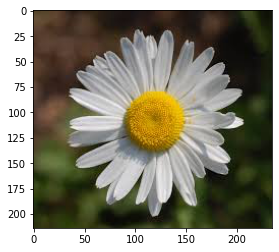

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread(img_path))
print(f"this image's label is {np.argmax(preds[0])}")

In [ ]:
# This is the "african elephant" entry in the prediction vector
# 會是一個值，當某一張輸入時，這個大象類別的輸出
# np.argmax(preds[0]) = 386
# or 985: flower
african_elephant_output = model.output[:, np.argmax(preds[0])]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
# 我們想觀察, 最後一層的輸出對 大象類別的影響，就是微分看敏感度
#grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
# shape is [14,14,512]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
# 
pooled_grads = K.mean(grads, axis=(0, 1, 2)) #shape is 512

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

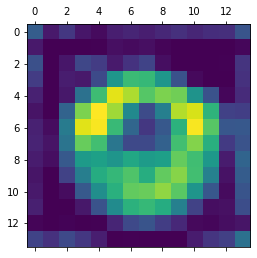

In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [ ]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite(path + 'elephant_cam.jpg', superimposed_img)

True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


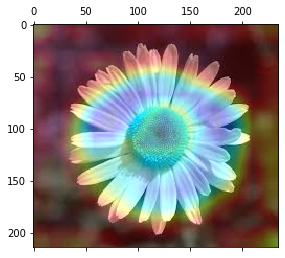

In [ ]:
plt.matshow(superimposed_img/300)
plt.show()

# <參考與說明>


# 程式目的

1. 了解**圖片**經過網路被處理的狀況
2. 知道 feature extraction from a NN
3. 學會慢慢看 code


In [ ]:
import keras
keras.__version__

'2.6.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/My Drive/ColabOK/DNN_CNN/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras.applications.vgg16 import VGG16
from keras import backend as K
import matplotlib.pyplot as plt

## Visualizing heatmaps of class activation

We will introduce one more visualization technique, one that is useful for understanding which parts of a given image led a convnet to its 
final classification decision. This is helpful for "debugging" the decision process of a convnet, in particular in case of a classification 
mistake. It also allows you to locate specific objects in an image.

This general category of techniques is called "Class Activation Map" (CAM) visualization, and consists in producing heatmaps of "class 
activation" over input images. A "class activation" heatmap is a 2D grid of scores associated with an specific output class, computed for 
every location in any input image, indicating how important each location is with respect to the class considered. For instance, given a 
image fed into one of our "cat vs. dog" convnet, Class Activation Map visualization allows us to generate a heatmap for the class "cat", 
indicating how cat-like different parts of the image are, and likewise for the class "dog", indicating how dog-like differents parts of the 
image are.

The specific implementation we will use is the one described in [Grad-CAM: Why did you say that? Visual Explanations from Deep Networks via 
Gradient-based Localization](https://arxiv.org/abs/1610.02391). It is very simple: it consists in taking the output feature map of a 
convolution layer given an input image, and weighing every channel in that feature map by the gradient of the class with respect to the 
channel. Intuitively, one way to understand this trick is that we are weighting a spatial map of "how intensely the input image activates 
different channels" by "how important each channel is with regard to the class", resulting in a spatial map of "how intensely the input 
image activates the class".

We will demonstrate this technique using the pre-trained VGG16 network again:

In [ ]:
from keras.applications.vgg16 import VGG16

#K.clear_session()


# Note that we are including the densely-connected classifier on top;
# all previous times, we were discarding it.
model = VGG16(weights='imagenet')

Let's consider the following image of two African elephants, possible a mother and its cub, strolling in the savanna (under a Creative 
Commons license):

![elephants](https://s3.amazonaws.com/book.keras.io/img/ch5/creative_commons_elephant.jpg)

Let's convert this image into something the VGG16 model can read: the model was trained on images of size 224x244, preprocessed according 
to a few rules that are packaged in the utility function `keras.applications.vgg16.preprocess_input`. So we need to load the image, resize 
it to 224x224, convert it to a Numpy float32 tensor, and apply these pre-processing rules.

In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# The local path to our target image
img_path = 'DNN_CNN/creative_commons_elephant.jpg'

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

In [ ]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0]) # this function is from vgg16, pls study keras.applications.vgg16

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Predicted: [('n02504458', 'African_elephant', 0.90942055), ('n01871265', 'tusker', 0.086183496), ('n02504013', 'Indian_elephant', 0.0043545887)]



The top-3 classes predicted for this image are:

* African elephant (with 92.5% probability)
* Tusker (with 7% probability)
* Indian elephant (with 0.4% probability)

Thus our network has recognized our image as containing an undetermined quantity of African elephants. The entry in the prediction vector 
that was maximally activated is the one corresponding to the "African elephant" class, at index 386:

In [ ]:
np.argmax(preds[0])

386

To visualize which parts of our image were the most "African elephant"-like, let's set up the Grad-CAM process:

In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# This is the "african elephant" entry in the prediction vector
# 會是一個值，當某一張輸入時，這個大象類別的輸出
african_elephant_output = model.output[:, 386]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
# 我們想觀察, 最後一層的輸出對 大象類別的影響，就是微分看敏感度
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
# 
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

For visualization purpose, we will also normalize the heatmap between 0 and 1:

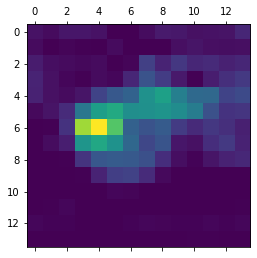

In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

Finally, we will use OpenCV to generate an image that superimposes the original image with the heatmap we just obtained:

In [ ]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite(path + 'elephant_cam.jpg', superimposed_img)

False

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


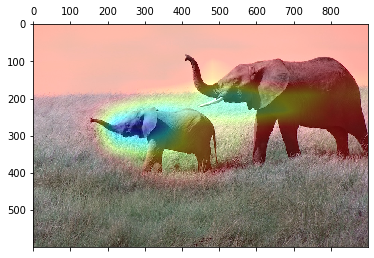

In [ ]:
plt.matshow(superimposed_img/300)
plt.show()

![elephant cam](https://s3.amazonaws.com/book.keras.io/img/ch5/elephant_cam.jpg)

This visualisation technique answers two important questions:

* Why did the network think this image contained an African elephant?
* Where is the African elephant located in the picture?

In particular, it is interesting to note that the ears of the elephant cub are strongly activated: this is probably how the network can 
tell the difference between African and Indian elephants.
